# Explainability

In [1]:
import joblib
import os
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report
from copy import deepcopy

os.environ["KERAS_BACKEND"] = "torch"
import keras
from libraries.supervision import create_model

In [2]:
MODELS_DIR = "models" + os.sep
MODEL_NAME = "best_rf.pkl"
DATASET_DIR = "dataset" + os.sep
TRAIN_NAME = "train_set.csv"
TEST_NAME = "test_set.csv"
PREPROCESSING_NAME = "nn_preprocessor.pkl"

In [3]:
if "keras" in MODEL_NAME:
    model = keras.models.load_model(MODELS_DIR + MODEL_NAME)
    preprocessor = joblib.load(MODELS_DIR + PREPROCESSING_NAME)
else:
    model = joblib.load(MODELS_DIR + MODEL_NAME)
    preprocessor = None
if "best_nn.pkl" == MODEL_NAME:
    model = model[1:]
train_df = pd.read_csv(DATASET_DIR + TRAIN_NAME)
test_df = pd.read_csv(DATASET_DIR + TEST_NAME)
y_train = train_df.pop("position")
X_train = train_df
y_test = test_df.pop("position")
X_test = test_df
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((554288, 11), (554288,), (35406, 11), (35406,))

In [4]:
X_train["season"] = X_train["season"].astype("category")
X_test["season"] = X_train["season"].astype("category")
X_train["continent"] = X_train["continent"].astype("category")
X_test["continent"] = X_train["continent"].astype("category")

# obtain mapping from category to integer
season_mapping = dict(enumerate(X_train["season"].cat.categories))
continent_mapping = dict(enumerate(X_train["continent"].cat.categories))

# use codes to replace category
X_train["season"] = X_train["season"].cat.codes
X_test["season"] = X_test["season"].cat.codes
X_train["continent"] = X_train["continent"].cat.codes
X_test["continent"] = X_test["continent"].cat.codes

full_dataset = pd.concat([X_train, X_test])

print(season_mapping)
print(continent_mapping)

{0: 'Fall', 1: 'Spring', 2: 'Summer', 3: 'Winter'}
{0: 'Africa', 1: 'Asia', 2: 'Europe', 3: 'North America', 4: 'Oceania', 5: 'South America'}


In [5]:
if preprocessor is None:

    original_pipeline = deepcopy(model)

    # telling one hot encoder to output pandas df and not numpy array
    model[-2].set_output(transform="pandas")
    model[-2]["onehot"].set_params(sparse_output=False)

    X_train_transformed = model[:-1].transform(X_train)
    X_test_transformed = model[:-1].transform(X_test)

    X_test_pre_ohe = model[:-2].transform(X_test)
    X_train_pre_ohe = model[:-2].transform(X_train)

else:

    original_preprocessor = deepcopy(preprocessor)

    preprocessor[-1].set_output(transform="pandas")
    preprocessor[-1]["onehot"].set_params(sparse_output=False)
    X_train_transformed = preprocessor.transform(X_train)
    X_test_transformed = preprocessor.transform(X_test)

    X_test_pre_ohe = preprocessor[:-1].transform(X_test)
    X_train_pre_ohe = preprocessor[:-1].transform(X_train)

In [7]:
X_train_stratify = X_train_transformed.copy()
X_test_stratify = X_test_transformed.copy()

X_train_stratify["position"] = y_train
X_test_stratify["position"] = y_test

categorical_columns = ["season", "continent", "profile", "position"]

## when using trees, we do not standardize, so we have to standardize before clustering
if "rf" in MODEL_NAME or "xgb" in MODEL_NAME:
    from sklearn.preprocessing import StandardScaler

    numerical_columns = X_train_stratify.columns.difference(categorical_columns)
    scaler = StandardScaler()
    X_train_stratify[numerical_columns] = scaler.fit_transform(
        X_train_stratify[numerical_columns]
    )
    X_test_stratify[numerical_columns] = scaler.transform(
        X_test_stratify[numerical_columns]
    )


# kmeans clustering, data already one hot encoded and standardized

from sklearn.cluster import KMeans

# For X_train
kmeans = KMeans(n_clusters=100, random_state=42)
kmeans.fit_predict(X_train_stratify.dropna())
centroids = kmeans.cluster_centers_
# for each centroid, obtain the closest data point
closest_points = []
for centroid in centroids:
    closest_points.append(
        np.argmin(np.linalg.norm(X_train_stratify.dropna() - centroid, axis=1))
    )

# now that i have index of closest points, i can obtain the actual data points
X_train_stratify = X_train_stratify.dropna().iloc[closest_points].reset_index(drop=True)
X_train_pre_ohe_stratify = X_train_pre_ohe.iloc[closest_points].reset_index(drop=True)
X_train_transformed_stratify = X_train_transformed.iloc[closest_points].reset_index(
    drop=True
)
y_train_stratify = X_train_stratify["position"].reset_index(drop=True)

# For X_test
kmeans_test = KMeans(n_clusters=100, random_state=42)
kmeans_test.fit_predict(X_test_stratify.dropna())
centroids_test = kmeans_test.cluster_centers_
# for each centroid, obtain the closest data point
closest_points_test = []
for centroid in centroids_test:
    closest_points_test.append(
        np.argmin(np.linalg.norm(X_test_stratify.dropna() - centroid, axis=1))
    )

# now that i have index of closest points, i can obtain the actual data points
X_test_stratify = (
    X_test_stratify.dropna().iloc[closest_points_test].reset_index(drop=True)
)
X_test_pre_ohe_stratify = (
    X_test_pre_ohe.dropna().iloc[closest_points_test].reset_index(drop=True)
)
X_test_transformed_stratify = (
    X_test_transformed.dropna().iloc[closest_points_test].reset_index(drop=True)
)
y_test_stratify = X_test_stratify["position"].reset_index(drop=True)

# check shapes
X_train_pre_ohe_stratify.shape, y_train_stratify.shape, X_test_pre_ohe_stratify.shape, y_test_stratify.shape

((100, 8), (100,), (100, 8), (100,))

In [8]:
X_train_transformed_stratify.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   season_0           100 non-null    float64
 1   season_1           100 non-null    float64
 2   season_2           100 non-null    float64
 3   season_3           100 non-null    float64
 4   continent_0        100 non-null    float64
 5   continent_1        100 non-null    float64
 6   continent_2        100 non-null    float64
 7   continent_3        100 non-null    float64
 8   continent_4        100 non-null    float64
 9   continent_5        100 non-null    float64
 10  profile_1.0        100 non-null    float64
 11  profile_2.0        100 non-null    float64
 12  profile_3.0        100 non-null    float64
 13  profile_4.0        100 non-null    float64
 14  profile_5.0        100 non-null    float64
 15  profile_nan        100 non-null    float64
 16  points             100 non-

In [9]:
X_train_pre_ohe_stratify.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   points             100 non-null    int64  
 1   length             100 non-null    float64
 2   profile            71 non-null     float64
 3   startlist_quality  100 non-null    int64  
 4   cyclist_age        100 non-null    float64
 5   BMI                83 non-null     float64
 6   season             100 non-null    int8   
 7   continent          100 non-null    int8   
dtypes: float64(4), int64(2), int8(2)
memory usage: 5.0 KB


In [10]:
if "keras" in MODEL_NAME:
    classifier = model
else:
    classifier = model[-1]

In [11]:
from sklearn.metrics import fbeta_score

y_pred = classifier.predict(X_test_transformed.values)
if "keras" in MODEL_NAME:
    y_pred = (y_pred > 0.5).astype(int)

validation_report = classification_report(
    y_test,
    y_pred,
    target_names=["non top-20", "top-20"],
    output_dict=True,
)
validation_df = pd.DataFrame(validation_report)

# manually doing the report for fbeta 0.5
fbeta = fbeta_score(y_test, y_pred, beta=0.5, average=None)
validation_df.loc["fbeta_0.5"] = [
    fbeta[0],
    fbeta[1],
    validation_report["accuracy"],
    np.nan,
    np.nan,
]
fbeta_weighted = fbeta_score(y_test, y_pred, beta=0.5, average="weighted")
fbeta_macro = fbeta_score(y_test, y_pred, beta=0.5, average="macro")
validation_df.loc["fbeta_0.5", "weighted avg"] = fbeta_weighted
validation_df.loc["fbeta_0.5", "macro avg"] = fbeta_macro
validation_df

,non top-20,top-20,accuracy,macro avg,weighted avg
precision,0.864913,0.271231,0.845563,0.568072,0.782080
recall,0.972395,0.063360,0.845563,0.517878,0.845563
f1-score,0.915510,0.102724,0.845563,0.509117,0.802107
support,30466.000000,4940.000000,0.845563,35406.000000,35406.000000
fbeta_0.5,0.884466,0.163771,0.845563,0.524119,0.783911


## SHAP

In [12]:
import shap
from shap._explanation import group_features

shap.initjs()

In [13]:
explanations = dict()

In [14]:
def f(X):
    # Keras models expect a numpy array for prediction
    predictions = classifier.predict(X)
    # Return class probabilities in shape (n_samples, n_classes)
    return np.hstack([1 - predictions, predictions])

In [15]:
if "keras" in MODEL_NAME:

    explainer = shap.KernelExplainer(f, X_train_transformed_stratify, link="logit")
else:
    explainer = shap.KernelExplainer(
        classifier.predict_proba, X_train_transformed_stratify, link="logit"
    )

In [16]:
int_expl = explainer(X_test_transformed_stratify.dropna())

explanations["shap"] = int_expl.values

  0%|          | 0/100 [00:00<?, ?it/s]

In [18]:
# Group one hot encoded explanations

feature_map = {
    col: "season" for col in X_train_transformed.columns if col.startswith("season_")
}
feature_map.update(
    {
        col: "continent"
        for col in X_train_transformed.columns
        if col.startswith("continent_")
    }
)
feature_map.update(
    {
        col: "profile"
        for col in X_train_transformed.columns
        if col.startswith("profile_")
    }
)

grouped_expl = group_features(int_expl, feature_map)

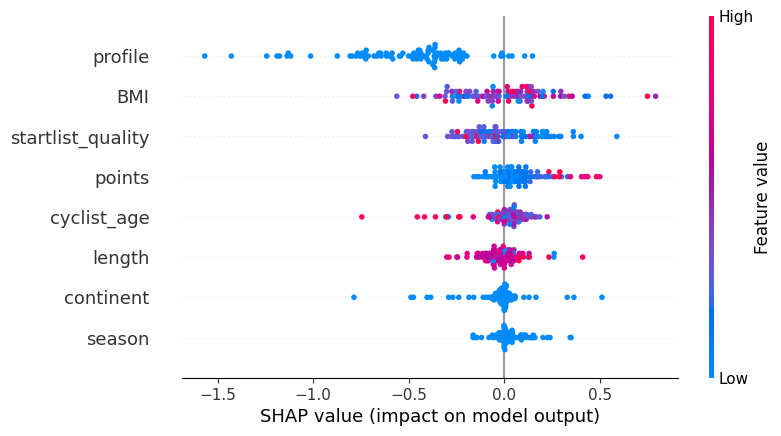

In [19]:
shap.plots.beeswarm(grouped_expl[:, :, 1])

### analyzing explanations shap

In [33]:
expl_df = pd.DataFrame(grouped_expl[:, :, 1].values, columns=grouped_expl.feature_names)
expl_df.describe().drop("count", axis="rows")

,points,BMI,cyclist_age,length,startlist_quality,profile,season,continent
mean,0.003289,0.023828,-0.026459,-0.001040,0.065496,-0.189479,0.011359,0.0
std,0.118985,0.262198,0.131650,0.064038,0.184404,0.253124,0.042246,0.0
min,-0.122423,-0.593074,-0.552402,-0.108393,-0.113590,-1.216751,-0.079275,0.0
25%,-0.057274,-0.090488,-0.056727,-0.027582,-0.012737,-0.239386,-0.021612,0.0
50%,-0.028913,-0.019946,0.023475,-0.018580,0.043080,-0.149666,0.013337,0.0
75%,0.011096,0.101372,0.068999,-0.007550,0.085209,-0.051573,0.048241,0.0
max,0.553869,0.743785,0.101355,0.231325,1.213465,0.327688,0.083315,0.0


### for which istances features more important?

<Axes: xlabel='BMI', ylabel='Density'>

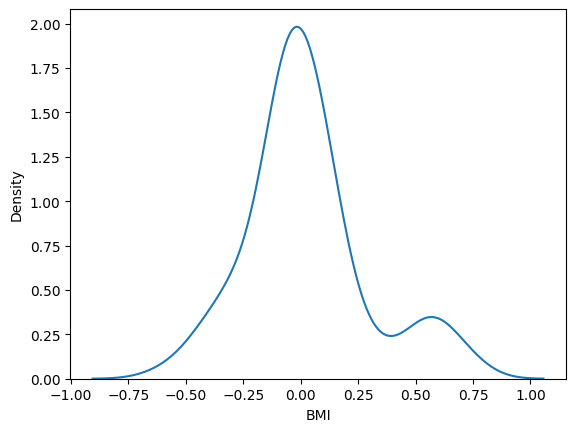

In [34]:
feature_of_interest = "BMI"
sns.kdeplot(expl_df, x=feature_of_interest)

<Axes: >

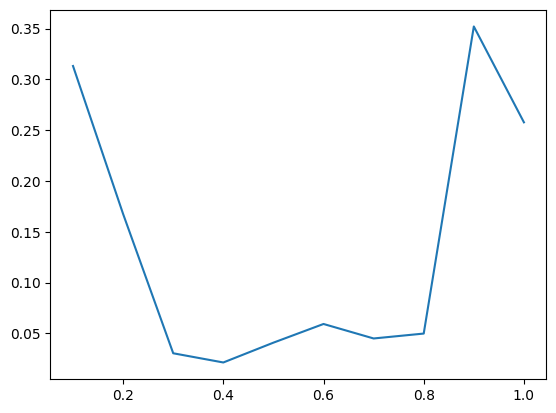

In [35]:
number_quantiles = 10
quantiles = expl_df[feature_of_interest].quantile(
    [i / number_quantiles for i in range(number_quantiles + 1)]
)
quantiles.diff().plot()

In [36]:
quantile_of_interest = quantiles[0.1]
interested_explanations = expl_df[feature_of_interest].values

highly_impacted_instances = np.argwhere(
    interested_explanations <= quantile_of_interest
).squeeze()
moderately_impacted_instances = np.array(
    [
        i
        for i in range(grouped_expl[:, :, 1].shape[0])
        if i not in highly_impacted_instances
    ]
)

### What are the differences in instances for which the selected features is highly important?

In [37]:
full_dataset.iloc[highly_impacted_instances].describe().drop(
    "count", axis="rows"
) - full_dataset.iloc[moderately_impacted_instances].describe().drop(
    "count", axis="rows"
)

,points,length,climb_total,profile,startlist_quality,cyclist_age,height,BMI,weight,season,continent
mean,0.0,0.0,0.0,0.0,0.0,-1.122222,1.972222,1.508714,6.352941,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,-0.868522,1.318428,-0.087231,2.689664,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,1.000000,3.000000,1.802630,3.000000,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.250000,1.750000,1.844278,6.500000,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,-1.000000,4.500000,1.247709,7.500000,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,-3.000000,2.750000,1.449033,10.000000,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,-6.000000,-4.000000,-0.867358,0.000000,0.0,0.0


<Axes: xlabel='BMI', ylabel='Density'>

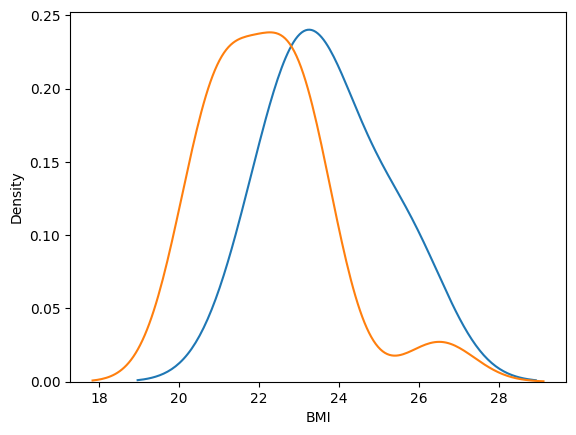

In [38]:
sns.kdeplot(full_dataset.iloc[highly_impacted_instances], x=feature_of_interest)
sns.kdeplot(full_dataset.iloc[moderately_impacted_instances], x=feature_of_interest)

### validation

In [ ]:
# ungroup_expl_df = pd.DataFrame(int_expl[:, :, 1].values, columns=int_expl.feature_names)

mean_abs_imp = expl_df.abs().mean()
feat_by_imp = expl_df.columns[mean_abs_imp.argsort()].tolist()
feat_by_imp

construct noised datasets

In [23]:
categorical_features = ["season", "profile", "continent"]

random_noise = np.random.rand(
    X_test_pre_ohe.shape[0],
)
noise_magnitudes = [eps / 10 for eps in range(1, 10)]

corruptions_by_feature_and_noise = dict()
for feature in feat_by_imp:
    if feature in categorical_features:
        # categorical features perturbation
        for noise_magnitude in noise_magnitudes:
            corrupted_data = X_test_pre_ohe.copy()
            mask = np.random.rand(corrupted_data.shape[0]) < noise_magnitude
            random_replacements = np.random.choice(
                corrupted_data[feature].unique(), size=mask.sum()
            )
            corrupted_data.loc[mask, feature] = random_replacements
            corruptions_by_feature_and_noise[(feature, noise_magnitude)] = (
                corrupted_data
            )
    else:
        for noise_magnitude in noise_magnitudes:
            corrupted_data = X_test_pre_ohe.copy()
            mean = corrupted_data[feature].mean()
            std = corrupted_data[feature].std()
            corrupted_data[feature] = (corrupted_data[feature] - mean) / std
            corrupted_data[feature] = (
                corrupted_data[feature] + noise_magnitude * random_noise
            ) * std + mean
            corruptions_by_feature_and_noise[(feature, noise_magnitude)] = (
                corrupted_data
            )

In [ ]:
validations_by_feature_and_noise = dict()
for (feature, noise), corruption in corruptions_by_feature_and_noise.items():
    print(f"Feature: {feature}, Noise: {noise}")
    validations_by_feature_and_noise[(feature, noise)] = pd.DataFrame(
        classification_report(
            y_test, original_pipeline[-2:].predict(corruption), output_dict=True
        )
    )
    fbeta = fbeta_score(
        y_test, original_pipeline[-2:].predict(corruption), beta=0.5, average=None
    )
    validations_by_feature_and_noise[(feature, noise)].loc["fbeta_0.5"] = [
        fbeta[0],
        fbeta[1],
        validations_by_feature_and_noise[(feature, noise)]["accuracy"].iloc[0],
        np.nan,
        np.nan,
    ]
    fbeta_weighted = fbeta_score(
        y_test, original_pipeline[-2:].predict(corruption), beta=0.5, average="weighted"
    )
    fbeta_macro = fbeta_score(
        y_test, original_pipeline[-2:].predict(corruption), beta=0.5, average="macro"
    )
    validations_by_feature_and_noise[(feature, noise)].loc[
        "fbeta_0.5", "weighted avg"
    ] = fbeta_weighted
    validations_by_feature_and_noise[(feature, noise)].loc[
        "fbeta_0.5", "macro avg"
    ] = fbeta_macro

In [ ]:
metric = "fbeta_0.5"

corruption_validation = pd.DataFrame(
    [
        (
            feature,
            noise,
            validations_by_feature_and_noise[(feature, noise)]["1"][metric],
            "shap",
        )
        for feature, noise in corruptions_by_feature_and_noise.keys()
    ],
    columns=["feature", "noise_magnitude", "performance", "algorithm"],
)

corruption_validation["difference"] = (
    corruption_validation["performance"] - validation_df.loc["fbeta_0.5", "top-20"]
)
corruption_validation.sort_values("difference", ascending=False)

In [ ]:
corruption_validation.groupby("feature").describe()[["performance", "difference"]]

In [ ]:
corruption_validation.groupby("noise_magnitude").describe()[
    ["performance", "difference"]
]

## LIME

In [49]:
from interpret import set_visualize_provider
from interpret.provider import InlineProvider
from interpret import show
from tqdm import tqdm
from interpret.blackbox import LimeTabular

set_visualize_provider(InlineProvider())

In [50]:
categorical_columns = ["season", "continent", "profile"]
categorical_feature_indices = [
    X_train_pre_ohe.columns.get_loc(col) for col in categorical_columns
]
categorical_feature_indices

[6, 7, 1]

In [51]:
explainer = LimeTabular(
    original_pipeline[-2:],
    X_train_pre_ohe.dropna().reset_index(drop=True).values,
    feature_names=X_train_pre_ohe.columns.tolist(),
    categorical_features=categorical_feature_indices,
    mode="classification",
)
explanations = np.array(
    [
        np.array(e["scores"])
        for e in tqdm(
            explainer.explain_local(
                X_test_pre_ohe_stratify, y_test_stratify
            )._internal_obj["specific"]
        )
    ]
)

100%|██████████| 1000/1000 [00:00<00:00, 1592370.54it/s]


## Lore

In [37]:
from xailib.explainers.lore_explainer import (
    LoreTabularExplainer,
    LOREM,
    prepare_dataset,
    LoreTabularExplanation,
)
import xailib.explainers.lore_explainer as lore

In [58]:
# lore_train_data = pd.concat((X_train_pre_ohe, y_train), axis=1)
# (
#     df,
#     feature_names,
#     class_values,
#     numeric_columns,
#     rdf,
#     real_feature_names,
#     features_map,
# ) = prepare_dataset(lore_train_data, "position")

In [60]:
# categorical_columns = ["season", "continent", "profile"]
# numeric_columns = [
#     col for col in X_train_pre_ohe.columns if col not in categorical_columns
# ]

In [ ]:
# features_map

In [ ]:
# from sklearn.compose import ColumnTransformer

# prep = original_pipeline[-2]
# numerical_features = ["points", "BMI", "cyclist_age", "length", "startlist_quality"]
# categorical_features = ["profile", "season", "continent"]

# numerical_indices = [X_train_pre_ohe.columns.get_loc(col) for col in numerical_features]
# categorical_indices = [
#     X_train_pre_ohe.columns.get_loc(col) for col in categorical_features
# ]

# updated_transformers = []
# for name, trans, columns in prep.transformers:
#     if name == "scaler":
#         updated_transformers.append((name, trans, numerical_indices))
#     elif name == "onehot":
#         updated_transformers.append((name, trans, categorical_indices))

# new_transformer = ColumnTransformer(
#     transformers=updated_transformers,
#     remainder="passthrough",
#     verbose_feature_names_out=False,
# )

# original_pipeline.set_params(encoder=new_transformer)
# res = original_pipeline[:-1].fit(X_train, y_train)
# res

In [ ]:
# from sklearn.utils.validation import check_is_fitted

# try:
#     check_is_fitted(original_pipeline)
#     print("Pipeline is fitted.")
# except:
#     print("Pipeline is not fitted.")

In [ ]:
# configuration = {"neigh_type": "rndgen", "size": 100, "ocr": 0.1, "ngen": 10}
# lore_explainer = LOREM(
#     rdf[real_feature_names].values,
#     original_pipeline[-2:].predict,
#     feature_names=feature_names,
#     class_name="position",
#     numeric_columns=numeric_columns,
#     class_values=class_values,
#     features_map=features_map,
#     categorical_use_prob=True,
#     continuous_fun_estimation=False,
#     random_state=0,
#     bb_predict_proba=original_pipeline[-2:].predict_proba,
#     verbose=True,
#     neigh_type=configuration["neigh_type"],
#     size=configuration["size"],
#     ocr=configuration["ocr"],
#     ngen=configuration["ngen"],
# )
# explanation = LoreTabularExplanation(
#     lore_explainer.explain_instance(
#         X_train_pre_ohe.iloc[0].values, samples=1000, use_weights=True
#     )
# )

In [44]:
explainer_lore = LoreTabularExplainer(classifier)
configuration = {"neigh_type": "rndgen", "size": 100, "ocr": 0.1, "ngen": 10}

lore_train_data = pd.concat((X_train_transformed, y_train), axis=1)
explainer_lore.fit(
    lore_train_data,
    "position",
    config=configuration,
)

In [45]:
explanation = explainer_lore.explain(X_test_transformed_stratify.iloc[0].values)

In [46]:
explanation.getRules()

{'premise': [{'att': 'profile_5.0',
   'op': '>',
   'thr': 0.5,
   'is_continuous': True},
  {'att': 'BMI', 'op': '>', 'thr': -0.5194624215364456, 'is_continuous': True},
  {'att': 'points',
   'op': '<=',
   'thr': 1.87633615732193,
   'is_continuous': True},
  {'att': 'continent_5', 'op': '<=', 'thr': 0.5, 'is_continuous': True}],
 'cons': 0,
 'class_name': 'position'}

In [47]:
explanation.getCounterfactualRules()

[{'premise': [{'att': 'profile_5.0',
    'op': '>',
    'thr': 0.5,
    'is_continuous': True},
   {'att': 'BMI',
    'op': '<=',
    'thr': -1.0516294240951538,
    'is_continuous': True},
   {'att': 'BMI',
    'op': '>',
    'thr': -2.1062179803848267,
    'is_continuous': True},
   {'att': 'profile_1.0', 'op': '<=', 'thr': 0.5, 'is_continuous': True}],
  'cons': 1,
  'class_name': 'position'},
 {'premise': [{'att': 'profile_5.0',
    'op': '>',
    'thr': 0.5,
    'is_continuous': True},
   {'att': 'BMI',
    'op': '<=',
    'thr': -2.1062179803848267,
    'is_continuous': True},
   {'att': 'profile_1.0', 'op': '<=', 'thr': 0.5, 'is_continuous': True}],
  'cons': 1,
  'class_name': 'position'}]

In [48]:
explanation.plotRules()

## DICE

In [24]:
import dice_ml

In [25]:
X_train_pre_ohe.info()
categorical_columns = ["season", "continent", "profile"]
continuous_features = [
    col for col in X_train_pre_ohe.columns if col not in categorical_columns
]
continuous_features

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 554288 entries, 0 to 554287
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   cyclist_age        554288 non-null  float64
 1   profile            554288 non-null  float64
 2   points             554288 non-null  int64  
 3   length             554288 non-null  float64
 4   startlist_quality  554288 non-null  int64  
 5   BMI                554288 non-null  float64
 6   season             554288 non-null  int8   
 7   continent          554288 non-null  int8   
dtypes: float64(4), int64(2), int8(2)
memory usage: 26.4 MB


['cyclist_age', 'points', 'length', 'startlist_quality', 'BMI']

In [26]:
X_train_pre_ohe.columns

Index(['cyclist_age', 'profile', 'points', 'length', 'startlist_quality',
       'BMI', 'season', 'continent'],
      dtype='object')

In [27]:
dice_train_data = X_train_pre_ohe.copy()
dice_train_data["position"] = y_train
dice_dataset = dice_ml.Data(
    dataframe=dice_train_data.dropna(),
    outcome_name="position",
    continuous_features=continuous_features,
)
dice_model = dice_ml.Model(model=original_pipeline[-2:], backend="sklearn")

In [28]:
print(original_pipeline[-2])

ColumnTransformer(remainder='passthrough',
                  transformers=[('scaler', StandardScaler(),
                                 ['points', 'BMI', 'cyclist_age', 'length',
                                  'startlist_quality']),
                                ('onehot',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['profile', 'season', 'continent'])],
                  verbose_feature_names_out=False)


In [30]:
explanation_algorithm = dice_ml.Dice(dice_dataset, dice_model, method="random")

explanation = explanation_algorithm.generate_counterfactuals(
    X_test_pre_ohe_stratify.head(1), total_CFs=10
)

100%|██████████| 1/1 [00:00<00:00,  2.56it/s]


In [33]:
# original_pipeline[-2:].predict_proba(
#     dice_train_data.head(1).drop("position", axis="columns")
# )

# query_instance = dice_train_data.head(1).drop("position", axis="columns")
# sample_size = 10
# candidate_cfs = pd.DataFrame(
#     np.repeat(query_instance.values, sample_size, axis=0),
#     columns=query_instance.columns,
# )
# original_pipeline[-2:].predict_proba(candidate_cfs)

In [31]:
explanation.visualize_as_dataframe(show_only_changes=True)

Query instance (original outcome : 1)


,cyclist_age,profile,points,length,startlist_quality,BMI,season,continent,position
0,31.0,5.0,50,143800.0,855,24.441803,2,2,1



Diverse Counterfactual set (new outcome: 0)


,cyclist_age,profile,points,length,startlist_quality,BMI,season,continent,position
0,-,-,-,-,-,-,-,-,-
1,-,-,-,-,-,-,-,5.0,-
2,-,-,-,-,-,-,-,4.0,-
3,-,-,-,-,-,-,-,-,-
4,19.3,-,-,-,1769.0,-,-,-,-
5,18.8,-,-,-,-,-,3.0,-,-
6,-,-,-,-,1858.0,-,-,-,-
7,50.4,-,-,-,-,-,-,-,-
8,-,-,-,-,-,25.650436,-,-,-
9,24.5,-,284.0,-,-,-,-,-,-
